In [20]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as onp

import pandas as pd

from functools import partial

import jax
from jax import vmap, jit

import jax.numpy as np
import jax.random as random

import numpyro
import numpyro.distributions as dist
from numpyro.infer import (
    MCMC,
    NUTS,
    init_to_feasible,
    init_to_median,
    init_to_sample,
    init_to_uniform,
    init_to_value,
)

key = random.PRNGKey(0)

In [190]:
# FROM LOCAL FILES
import os
import sys

from jax.scipy.linalg import cholesky

path_project_modules = os.path.join('modules')
sys.path.insert(1, path_project_modules)

from ridge import cov_map, softplus, vec_interp, cov_inv_matr

# Mixture model

In [21]:
sq_exp = lambda x, y, l, v: v*np.exp(-.5*np.power((x-y)/l,2))

# compute covariance matrix for xs, xs2
@partial(jit, static_argnums=(0))
def cov_map(cov_func, xs, xs2 = None):
    # xs and xs2 are stacked along the leading dimension
    if xs2 is None:
        return vmap(lambda x:  vmap(lambda y: cov_func(x, y))(xs))(xs)
    else:
        return vmap(lambda x: vmap(lambda y: cov_func(x, y))(xs))(xs2).T

# squared exponential kernel with diagonal noise term
def cov_matr(X, Z, var, length, noise, jitter=1.0e-6, include_noise=True):
    """
    Return covariance matrix of size X x Z
    """
    
    return cov_map(partial(sq_exp, l = length, v = var), X, Z) + \
                (noise*include_noise + jitter) * np.eye(X.shape[0], Z.shape[0])

In [83]:
kernel = cov_matr

In [223]:
def predict(rng_key, X, Y, X_test, var, length, noise):
    # compute kernels between train and test data, etc.
    k_pp = kernel(X_test, X_test, var, length, noise, include_noise=True)
    k_pX = kernel(X_test, X, var, length, noise, include_noise=False)
    k_XX = kernel(X, X, var, length, noise, include_noise=True)
    K_xx_inv = np.linalg.inv(k_XX)
    
    K = k_pp - np.matmul(k_pX, np.matmul(K_xx_inv, np.transpose(k_pX)))
    
    # generate random noise with GP variance at each test point
    sigma_noise = np.sqrt(np.clip(np.diag(K), a_min=0.0)) * jax.random.normal(
        rng_key, X_test.shape[:1])
    mean = np.matmul(k_pX, np.matmul(K_xx_inv, Y))
    # we return both the mean function and a sample from the posterior predictive for the
    # given set of hyperparameters
    
    print(np.diag(K))
    return mean, mean + sigma_noise

Generate data from 2 GPs

In [52]:
t = np.linspace(-1, 1., 200)

In [76]:
key1, key2, key = random.split(key, 3)

K1 = 10
K2 = 10

In [53]:
x1 = random.uniform(key1, (K1, ), minval = -1, maxval = 0).sort()
x2 = random.uniform(key2, (K2, ), minval = 0, maxval = 1.).sort()

In [229]:
key, _ = random.split(key)

var1 = 1. 
length1 = .025 
noise1 = 0.
k1 = cov_matr(x1, x1, var1, length1, noise1, include_noise=False)

y1 = random.multivariate_normal(key, np.zeros(x1.shape), cov = k1, shape = ())
m1, ms = predict(key, x1, y1, t, var1, length1, noise1)

[8.3290112e-01 5.8232206e-01 2.4641848e-01 1.7775416e-02 5.7982087e-02
 2.5802094e-01 3.3018237e-01 1.7364144e-01 8.2502961e-03 8.5476696e-02
 3.8704538e-01 7.0351160e-01 8.9643443e-01 9.7384858e-01 9.9522382e-01
 9.9936950e-01 9.9994016e-01 9.9998945e-01 9.9990177e-01 9.9903369e-01
 9.9315733e-01 9.6495163e-01 8.7007469e-01 6.5139544e-01 3.2298058e-01
 4.8317552e-02 3.1700552e-02 2.8689802e-01 6.1987191e-01 8.5323393e-01
 9.5801198e-01 9.8449397e-01 9.6213257e-01 8.6532283e-01 6.4252615e-01
 3.1260824e-01 4.3239117e-02 3.6111236e-02 2.9713070e-01 6.2902033e-01
 8.5827506e-01 9.6081060e-01 9.9215710e-01 9.9886405e-01 9.9987149e-01
 9.9985778e-01 9.9873775e-01 9.9139684e-01 9.5758438e-01 8.4878767e-01
 6.1051351e-01 2.7608019e-01 2.8545856e-02 4.2700648e-02 2.3265249e-01
 3.1314343e-01 1.6789836e-01 7.9419613e-03 8.1568420e-02 3.4536475e-01
 5.2767205e-01 4.4199586e-01 1.7740017e-01 5.5396557e-03 5.9255481e-02
 1.5631819e-01 9.6991062e-02 8.5532665e-04 1.1063743e-01 4.2124712e-01
 7.294

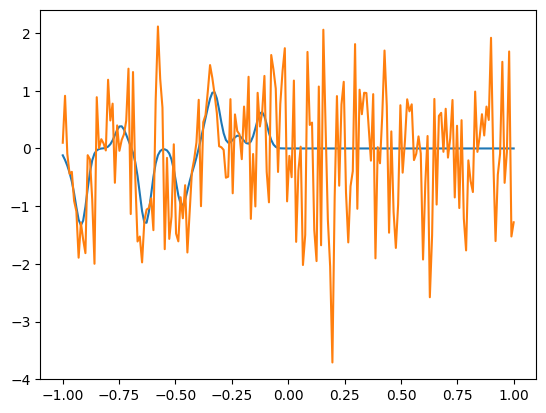

In [230]:
plt.plot(t, m1)
plt.plot(t, ms)

In [63]:
var2 = 1. 
length2 = .15 
noise2 = 0.
k2 = cov_matr(x2, x2, var2, length2, noise2, include_noise=False)

y2 = random.multivariate_normal(key, np.zeros(x2.shape), cov = k2, shape = ())
m2, ms = predict(key, x2, y2, t, var2, length2, noise2)

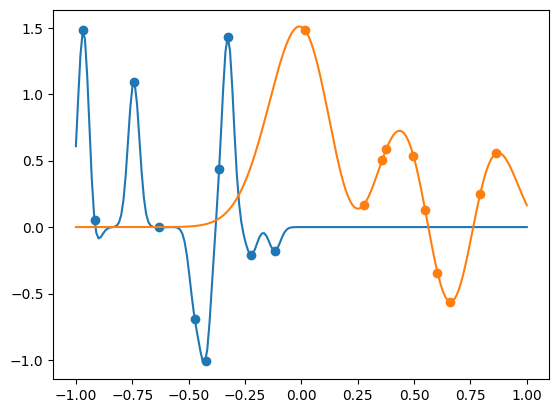

In [66]:
plt.scatter(x1, y1)
plt.scatter(x2, y2)
plt.plot(t, m1)
plt.plot(t, m2)




In [155]:
noise = 0.1
matr_inv = cov_inv_matr(x1, partial(sq_exp, l = length1, v = var1)) + np.eye(x1.size)*noise

In [154]:
x1.size

10

## Generate using my routines

In [156]:
mm1 = vec_interp(x1, y1, matr_inv, partial(sq_exp, l = length1, v = var1), t)

In [170]:
def predict1(x, y, t, kern, noise):
    
    # prediction from a GP with kernel function kern(x,y)
    # x, y - training data
    # t - test points
    # noise - observation noise
    # kern - kernel fun of (x,y), e.g. partial(sq_exp, l = length, v = var)
    
    # returns mean of GP
    
    matr_inv = cov_inv_matr(x, kern) + np.eye(x.size)*noise
    return vec_interp(x, y, matr_inv, kern, t)

In [171]:
mm1 = predict1(x1, y1, t, 
               partial(sq_exp, l = length1, v = var1),
              0.)

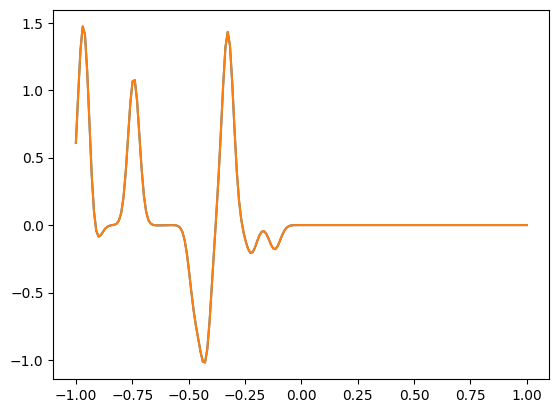

In [172]:
plt.plot(t, mm1)
plt.plot(t, m1)

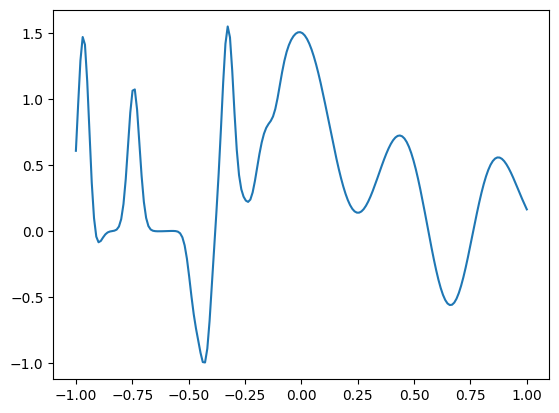

In [68]:
plt.plot(t, m1+m2);

## Add uncertainty: sample N-noise with GP variance at each test point

In [181]:
noise = 0.

In [182]:
cross_cov = cov_map(partial(sq_exp, l = length1, v = var1), 
                    t, 
                    x1)

In [183]:
cov_inv = cov_inv_matr(x1, 
                       partial(sq_exp, l = length1, v = var1)) + np.eye(x1.size)*noise

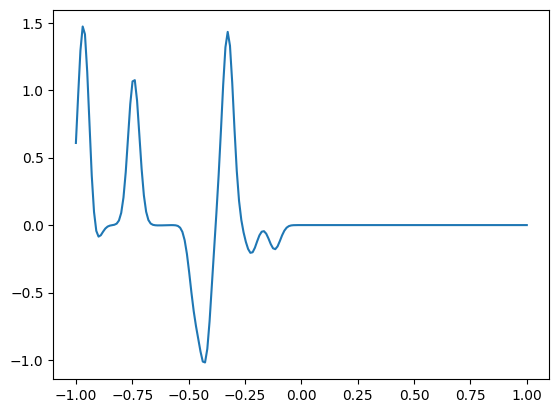

In [186]:
plt.plot(t, np.dot(cross_cov, cov_inv @ y1))

In [187]:
cross_cov.shape

(200, 10)

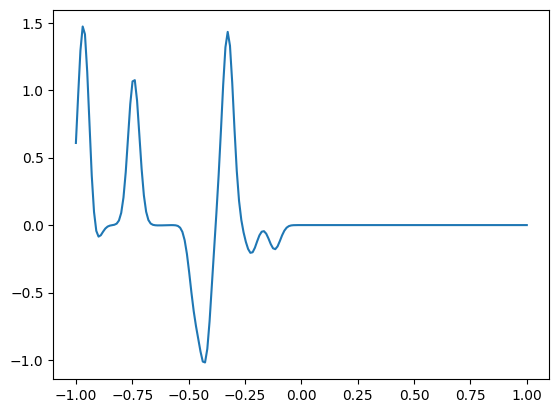

In [188]:
plt.plot(t, cross_cov @ cov_inv @ y1)

In [192]:
K = cross_cov @ cov_inv

In [194]:
K @ cross_cov.T

DeviceArray([[0.16709913, 0.26416537, 0.3545799 , ..., 0.        ,
              0.        , 0.        ],
             [0.2641654 , 0.4176794 , 0.56082374, ..., 0.        ,
              0.        , 0.        ],
             [0.3545799 , 0.56082374, 0.75358313, ..., 0.        ,
              0.        , 0.        ],
             ...,
             [0.        , 0.        , 0.        , ..., 0.        ,
              0.        , 0.        ],
             [0.        , 0.        , 0.        , ..., 0.        ,
              0.        , 0.        ],
             [0.        , 0.        , 0.        , ..., 0.        ,
              0.        , 0.        ]], dtype=float32)

In [216]:
@partial(jit, static_argnums=(1))   
def cov_inv_matr(X_t, kernel_fun, observation_noise):
    # inverse covariance matrix of kernel evaluated on nodes X_t
    # eps is our nugget to avoid non-psd covariance
    
    eps = 1e-7 # nugget for X_t covariance, i.e. Gaussian noise for point jitter
    Nt = X_t.shape[0] # number of nodes for RKHS matrix interpolation
    train_cov =  cov_map(kernel_fun, X_t) + np.eye(Nt) * eps + np.eye(X_t.size)*observation_noise
    
    chol = cholesky(train_cov, lower=True)
    c = np.linalg.inv(chol); 
    return np.dot(c.T,c)

In [235]:
def predict11(key, x, y, t, kern, observation_noise):
    
    # prediction from a GP with kernel function kern(x,y)
    # x, y - training data
    # t - test points
    # noise - observation noise
    # kern - kernel fun of (x,y), e.g. partial(sq_exp, l = length, v = var)
    
    # returns mean of GP
    
    cov_inv = cov_inv_matr(x, kern, observation_noise) 
    
    cross_cov = cov_map(kern, t, x)
    
    K = cross_cov @ cov_inv
    
    # GP posterior mean at t
    posterior_mean = K @ y
    
    # GP posterior covariance at t
    posterior_cov = cov_map(kern, t) - K @ cross_cov.T
 
        
    return posterior_mean, posterior_cov

In [ ]:
def uncrt(key, posterior_mean, posterior_cov):
    # Gaussian random noise with posterior variance, around posterior mean
    
    sigma_noise = np.sqrt(np.clip(np.diag(posterior_cov), a_min=0.0)) \
    * random.normal(key, t.shape)
    
    return posterior_mean+sigma_noise

In [231]:
m11, sm11, pc11 = predict11(key, 
                      x1, y1, t, 
                      partial(sq_exp, l = length1, v = var1),
                      .1)

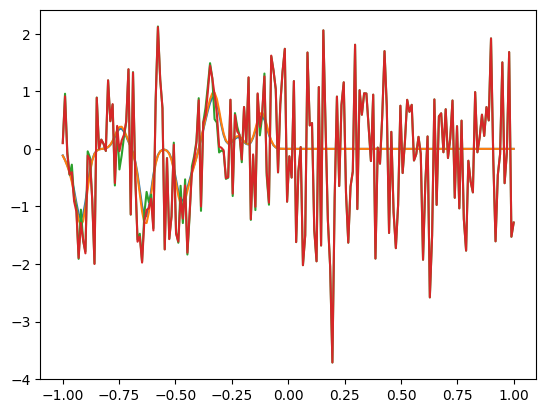

In [234]:
plt.plot(t, m11)
plt.plot(t, m1)
plt.plot(t, sm11)
plt.plot(t, ms)

### Fit model

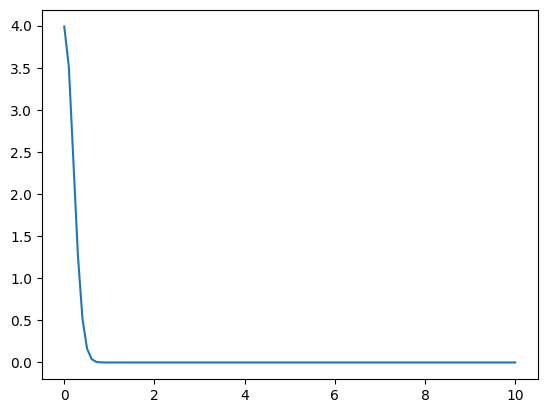

In [122]:
q = np.linspace(0, 10, 100)
plt.plot(q, np.exp(dist.HalfNormal(.2).log_prob(q)))

In [128]:
def model(N1, X, Y):
    # GPs on 2 intervals
    
    
    X1 = X[:N1]
    X2 = X[N1:]
    
    Y1 = Y[:N1]
    Y2 = Y[N1:]
    
    # set uninformative log-normal priors on our three kernel hyperparameters
    var1 = numpyro.sample("kernel_var1", dist.LogNormal(0.0, 10.0))
    noise1 = numpyro.sample("kernel_noise1", dist.LogNormal(0.0, 20.0))
    length1 = numpyro.sample("kernel_length1", dist.HalfNormal(.2))

    # compute kernel
    k1 = kernel(X1, X1, var1, length1, noise1)

    
    # set uninformative log-normal priors on our three kernel hyperparameters
    var2 = numpyro.sample("kernel_var2", dist.LogNormal(0.0, 10.0))
    noise2 = numpyro.sample("kernel_noise2", dist.LogNormal(0.0, 10.0))
    length2 = numpyro.sample("kernel_length2", dist.LogNormal(0.0, 10.0))

    # compute kernel
    k2 = kernel(X2, X2, var2, length2, noise2)

    
    # sample Y according to the standard gaussian process formula
    numpyro.sample(
        "Y1",
        dist.MultivariateNormal(loc=np.zeros(X1.shape[0]), covariance_matrix=k1),
        obs=Y1,
    )
    
    numpyro.sample(
        "Y2",
        dist.MultivariateNormal(loc=np.zeros(X2.shape[0]), covariance_matrix=k2),
        obs=Y2,
    )

In [129]:
N_mcmc = 1000
mcmc = MCMC(
        NUTS(model),
        num_warmup=1000,
        num_samples=N_mcmc,
        num_chains=1
    )

In [130]:
np.concatenate((x1, x2)).shape, np.concatenate((y1, y2)).shape

((20,), (20,))

In [131]:
key, key1 = random.split(key)
mcmc.run(key, 10, np.concatenate((x1, x2)), np.concatenate((y1, y2)))

sample: 100%|█| 2000/2000 [00:06<00:00, 328.75it/s, 15 steps of size 2.42e-01. a


In [132]:
mcmc.print_summary()


                      mean       std    median      5.0%     95.0%     n_eff     r_hat
  kernel_length1      0.04      0.02      0.04      0.00      0.07    125.24      1.01
  kernel_length2      0.15      0.02      0.15      0.13      0.18    377.78      1.00
   kernel_noise1      0.03      0.14      0.00      0.00      0.04    430.45      1.00
   kernel_noise2      0.00      0.00      0.00      0.00      0.00    992.27      1.00
     kernel_var1      1.06      0.77      0.84      0.31      1.88    249.73      1.01
     kernel_var2      1.07      0.98      0.80      0.25      1.99    341.81      1.00

Number of divergences: 89


In [70]:
mixing_dist = dist.Categorical(probs=np.ones(3) / 3.)

In [71]:
component_dist = dist.Normal(loc=np.zeros(3), scale=np.ones(3))

In [72]:
mixture = dist.MixtureSameFamily(mixing_dist, component_dist)

In [73]:
mixture.sample(jax.random.PRNGKey(42))

DeviceArray(1.3625766, dtype=float32)

In [75]:
component_dist.batch_shape

(3,)